In [ ]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:

#  dataset root

DATASET_ROOT = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"

classes = {
    "COVID": "COVID",
    "NORMAL": "Normal",
    "Viral Pneumonia": "Viral Pneumonia",
    "Lung_Opacity": "Lung_Opacity"
}


In [ ]:

#  Select EXACTLY 1500 images/class

selected_root = "/content/selected_xray"
if os.path.exists(selected_root):
    shutil.rmtree(selected_root)
os.makedirs(selected_root, exist_ok=True)

MAX_PER_CLASS = 1500

for label_name, folder_name in classes.items():

    src_folder = os.path.join(DATASET_ROOT, folder_name, "images")  # <--- FIXED

    dst_folder = os.path.join(selected_root, label_name)
    os.makedirs(dst_folder, exist_ok=True)

    imgs = [
        os.path.join(src_folder, f)
        for f in os.listdir(src_folder)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]

    random.shuffle(imgs)
    selected = imgs[:MAX_PER_CLASS]

    for img in selected:
        shutil.copy(img, dst_folder)

print("Dataset successfully copied to:", selected_root)
print("Folders now:", os.listdir(selected_root))

Dataset successfully copied to: /content/selected_xray
Folders now: ['Viral Pneumonia', 'NORMAL', 'Lung_Opacity', 'COVID']


In [ ]:

#  Generate Spirometry Data

rows = []

for cls in os.listdir(selected_root):
    folder = os.path.join(selected_root, cls)
    for fname in os.listdir(folder):

        path_img = os.path.join(folder, fname)

        if cls == "COVID":
            fvc = np.random.normal(2.2, 0.3)
            fev1 = np.random.normal(1.8, 0.2)
            pefr = np.random.normal(190, 30)
        elif cls == "NORMAL":
            fvc = np.random.normal(3.8, 0.3)
            fev1 = np.random.normal(3.2, 0.2)
            pefr = np.random.normal(430, 30)
        elif cls == "Viral Pneumonia":
            fvc = np.random.normal(2.9, 0.3)
            fev1 = np.random.normal(2.3, 0.2)
            pefr = np.random.normal(310, 30)
        else:
            fvc = np.random.normal(2.6, 0.3)
            fev1 = np.random.normal(2.1, 0.2)
            pefr = np.random.normal(260, 30)

        rows.append([path_img, cls, fvc, fev1, pefr])

df = pd.DataFrame(rows, columns=["image_path", "label", "fvc", "fev1", "pefr"])
print(df.head())


                                          image_path            label  \
0  /content/selected_xray/Viral Pneumonia/Viral P...  Viral Pneumonia   
1  /content/selected_xray/Viral Pneumonia/Viral P...  Viral Pneumonia   
2  /content/selected_xray/Viral Pneumonia/Viral P...  Viral Pneumonia   
3  /content/selected_xray/Viral Pneumonia/Viral P...  Viral Pneumonia   
4  /content/selected_xray/Viral Pneumonia/Viral P...  Viral Pneumonia   

        fvc      fev1        pefr  
0  3.049014  2.272347  329.430656  
1  3.356909  2.253169  302.975891  
2  3.373764  2.453487  295.915768  
3  3.062768  2.207316  296.028107  
4  2.972589  1.917344  258.252465  


In [ ]:

#  Load Images

IMG_SIZE = 224

X, y = [], []
class_names = sorted(df.label.unique())
class_to_idx = {c: i for i, c in enumerate(class_names)}

for _, row in df.iterrows():
    img = cv2.imread(row.image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    X.append(img / 255.)
    y.append(class_to_idx[row.label])

X = np.array(X)
y = np.array(y)

print("Loaded images:", X.shape)


Loaded images: (200, 224, 224, 3)


In [ ]:

#  Train/Test Split

X_train, X_test, y_train, y_test, spi_train, spi_test = train_test_split(
    X, y, df[["fvc", "fev1", "pefr"]],
    test_size=0.2, stratify=y, random_state=42
)

In [ ]:
#  CNN (VGG16)

base = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

for l in base.layers:
    l.trainable = False

x = Flatten()(base.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(len(class_names), activation="softmax")(x)

cnn = Model(inputs=base.input, outputs=out)
cnn.compile(optimizer=Adam(1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=6, batch_size=16)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 124s 13s/step - accuracy: 0.2963 - loss: 1.5352 - val_accuracy: 0.4750 - val_loss: 1.1305
Epoch 2/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 101s 10s/step - accuracy: 0.6619 - loss: 0.9160 - val_accuracy: 0.7500 - val_loss: 0.9170
Epoch 3/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.8013 - loss: 0.6066 - val_accuracy: 0.7500 - val_loss: 0.8463
Epoch 4/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 101s 10s/step - accuracy: 0.8796 - loss: 0.4807 - val_accuracy: 0.7500 - val_loss: 0.8127
Epoch 5/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.9070 - loss: 0.4503 - val_accuracy: 0.7750 - val_loss: 0.7881
Epoch 6/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 102s 10s/step - accuracy: 0.9307 - loss: 0.3532 - val_accuracy: 0.7500 - val_loss: 0.7450


In [ ]:
feat_model = Model(inputs=cnn.input, outputs=cnn.layers[-2].output)

train_feat = feat_model.predict(X_train)
test_feat  = feat_model.predict(X_test)

pca = PCA(n_components=13)
train_pca = pca.fit_transform(train_feat)
test_pca  = pca.transform(test_feat)

spi_min, spi_max = spi_train.min(), spi_train.max()
spi_train_norm = (spi_train - spi_min) / (spi_max - spi_min)
spi_test_norm  = (spi_test - spi_min) / (spi_max - spi_min)

X_dnn_train = np.hstack([train_pca, spi_train_norm])
X_dnn_test  = np.hstack([test_pca,  spi_test_norm])


5/5 ━━━━━━━━━━━━━━━━━━━━ 86s 16s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step


In [ ]:

#  DNN

dnn = Sequential([
    Dense(128, activation="relu", input_shape=(16,)),
    Dropout(0.3),
    Dense(len(class_names), activation="softmax")
])

dnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

dnn.fit(X_dnn_train, y_train, validation_data=(X_dnn_test, y_test), epochs=25, batch_size=8)


Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5200 - loss: 1.0895 - val_accuracy: 0.7000 - val_loss: 0.9558
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8915 - loss: 0.6432 - val_accuracy: 0.7750 - val_loss: 0.8103
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9347 - loss: 0.4119 - val_accuracy: 0.7750 - val_loss: 0.7401
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9533 - loss: 0.2831 - val_accuracy: 0.7750 - val_loss: 0.6958
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9647 - loss: 0.2390 - val_accuracy: 0.7750 - val_loss: 0.6604
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9520 - loss: 0.1947 - val_accuracy: 0.7750 - val_loss: 0.6363
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9442 - loss: 0.1619 - val_accuracy: 0.7750 - val_loss: 0.6233
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9723 - loss: 0.1513 - val_accuracy: 0.7750 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.80      0.80      0.80        10
   Lung_Opacity       0.90      0.90      0.90        10
         NORMAL       0.75      0.60      0.67        10
Viral Pneumonia       0.75      0.90      0.82        10

       accuracy                           0.80        40
      macro avg       0.80      0.80      0.80        40
   weighted avg       0.80      0.80      0.80        40



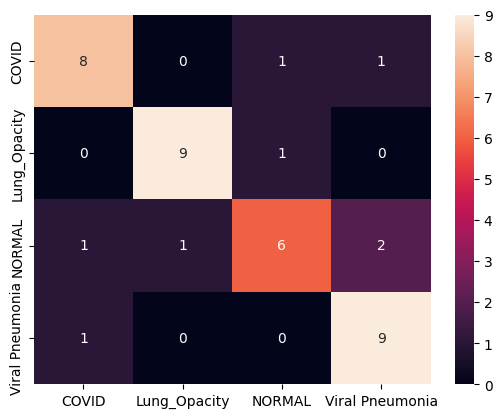

In [ ]:

#  Evaluation

y_pred = np.argmax(dnn.predict(X_dnn_test), axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.show()

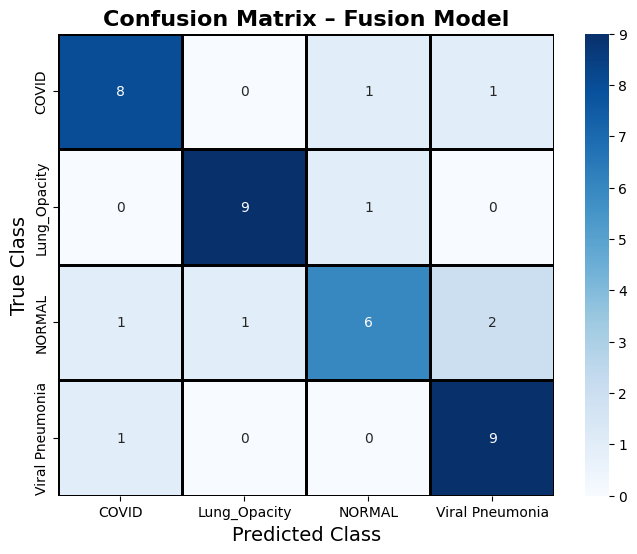

In [ ]:

#   CONFUSION MATRIX VISUALIZATION

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,
    linecolor='black'
)

plt.title("Confusion Matrix – Fusion Model", fontsize=16, weight="bold")
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.show()



📌 Number of samples per disease category:

label
Viral Pneumonia    50
NORMAL             50
Lung_Opacity       50
COVID              50
Name: count, dtype: int64


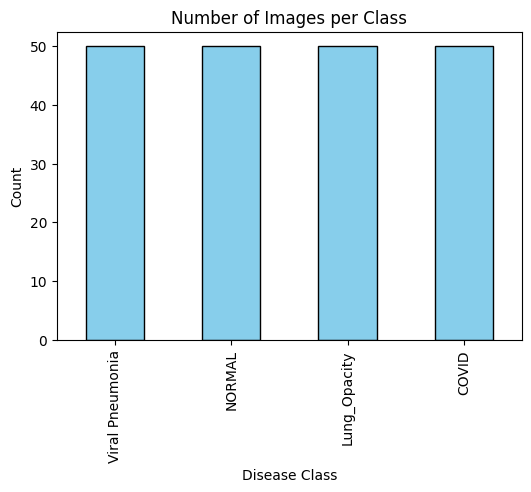

In [ ]:

#  CLASS DISTRIBUTION

print("\n📌 Number of samples per disease category:\n")
print(df["label"].value_counts())

plt.figure(figsize=(6,4))
df["label"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Number of Images per Class")
plt.xlabel("Disease Class")
plt.ylabel("Count")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

Predicted Disease: COVID


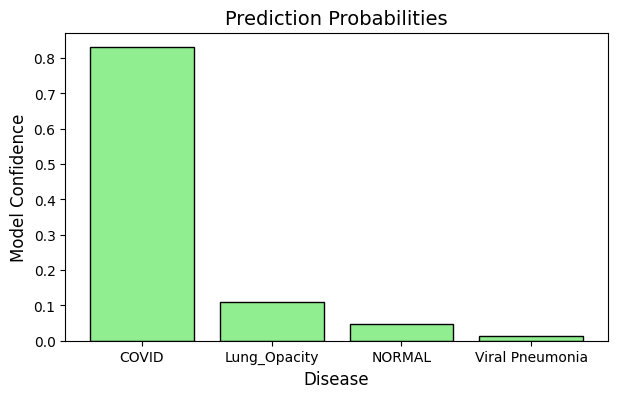

In [ ]:

#  PREDICTION PROBABILITY BAR CHART


sample_index = 0  # Change this to test another sample

# Use the correct variable name
probs = dnn.predict(X_dnn_test[sample_index].reshape(1, -1))[0]
predicted_label = class_names[np.argmax(probs)]

print("\nPredicted Disease:", predicted_label)

plt.figure(figsize=(7,4))
plt.bar(class_names, probs, color="lightgreen", edgecolor="black")
plt.title("Prediction Probabilities", fontsize=14)
plt.ylabel("Model Confidence", fontsize=12)
plt.xlabel("Disease", fontsize=12)
plt.show()


In [ ]:

#  HUMAN-FRIENDLY DISEASE INTERPRETATION

explain = {
    "COVID": "COVID-19 infection affects lung tissue causing ground-glass opacities.",
    "NORMAL": "No abnormal patterns detected. Lung appears healthy.",
    "Viral Pneumonia": "Opacity patches indicate viral pneumonia infection.",
    "Lung_Opacity": "Lung opacity indicates fluid deposition or inflammation."
}

print("\n Interpretation:")
print(explain[predicted_label])



 Interpretation:


NameError: name 'predicted_label' is not defined

In [ ]:

#  SPIROMETRY INTERPRETATION


fvc, fev1, pefr = spi_test.iloc[sample_index]

severity = ""

if fev1 >= 3.0:
    severity = "Normal Lung Function"
elif 2.0 <= fev1 < 3.0:
    severity = "Mild Obstruction"
elif 1.0 <= fev1 < 2.0:
    severity = "Moderate Obstruction"
else:
    severity = "Severe Obstruction"

print("\n Spirometry Values:")
print("FVC:", round(fvc,2))
print("FEV1:", round(fev1,2))
print("PEFR:", round(pefr,2))

print("\n Spirometry Interpretation:", severity)



 Spirometry Values:
FVC: 2.0
FEV1: 1.81
PEFR: 164.19

 Spirometry Interpretation: Moderate Obstruction


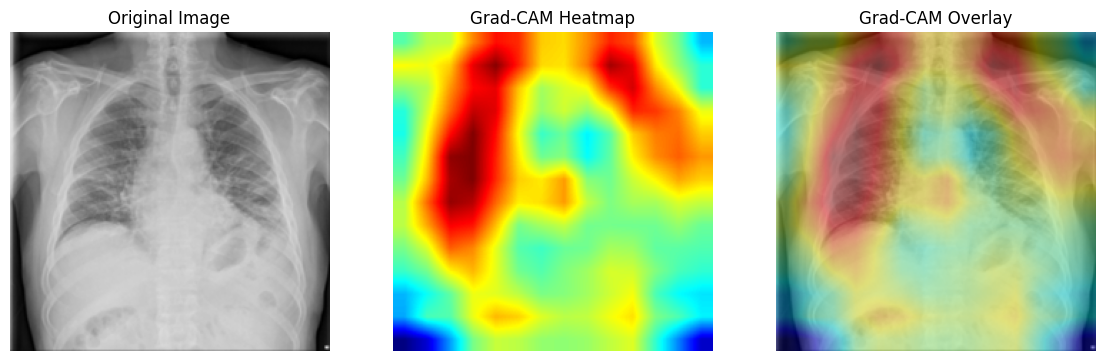

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Predicted: COVID
True: COVID


In [ ]:

#  GRAD-CAM IMPLEMENTATION


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])

        pred_output = predictions[:, pred_index]

    grads = tape.gradient(pred_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



#  APPLY GRAD-CAM TO A TEST IMAGE


last_conv_layer_name = "block5_conv3"

idx = 0   # change index to view another image

test_image = X_test[idx]
input_array = np.expand_dims(test_image, axis=0)

heatmap = make_gradcam_heatmap(input_array, cnn, last_conv_layer_name)


#  DISPLAY GRAD-CAM


heatmap = cv2.resize(heatmap, (test_image.shape[1], test_image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(
    (test_image * 255).astype("float32"),
    0.6,
    heatmap_color.astype("float32"),
    0.4,
    0
)

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap_color)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img.astype("uint8"))
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.show()



#  FUSION MODEL PREDICTION


fusion_input = X_dnn_test[idx].reshape(1, -1)

predicted_label = class_names[np.argmax(dnn.predict(fusion_input))]
true_label = class_names[y_test[idx]]

print("\nPredicted:", predicted_label)
print("True:", true_label)



================= OUTPUT'S=================


================= MODEL CLASSIFICATION REPORT =================

                 precision    recall  f1-score   support

          COVID       0.80      0.80      0.80        10
   Lung_Opacity       0.90      0.90      0.90        10
         NORMAL       0.75      0.60      0.67        10
Viral Pneumonia       0.75      0.90      0.82        10

       accuracy                           0.80        40
      macro avg       0.80      0.80      0.80        40
   weighted avg       0.80      0.80      0.80        40


===== Classification Metrics Table =====

                 precision  recall  f1-score  support
COVID                 0.80     0.8  0.800000     10.0
Lung_Opacity          0.90     0.9  0.900000     10.0
NORMAL                0.75     0.6  0.666667     10.0
Viral Pneumonia       0.75     0.9  0.818182     10.0
accuracy              0.80     0.8  0.800000      0.8
macro avg             0.80     0.8  0.796212     40.0
weighted

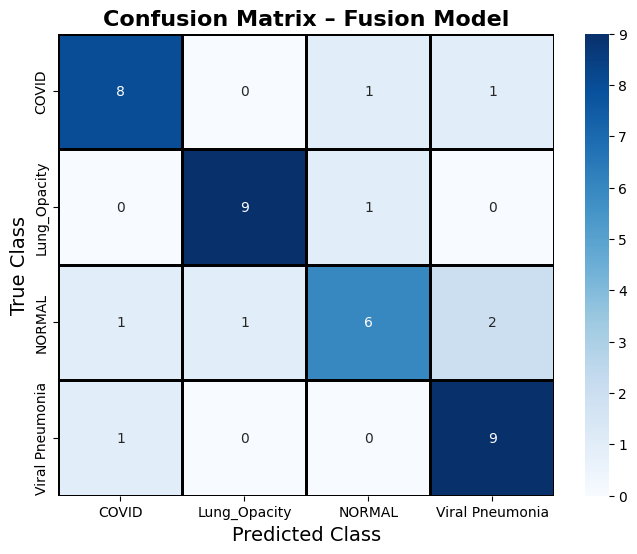


================= PER CLASS ACCURACY =================

             Class  Accuracy
0            COVID       0.8
1     Lung_Opacity       0.9
2           NORMAL       0.6
3  Viral Pneumonia       0.9


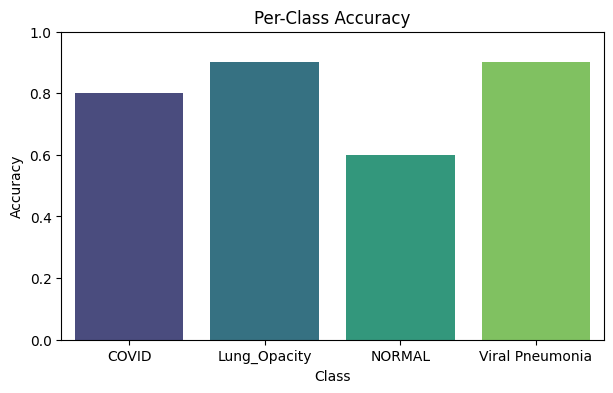

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


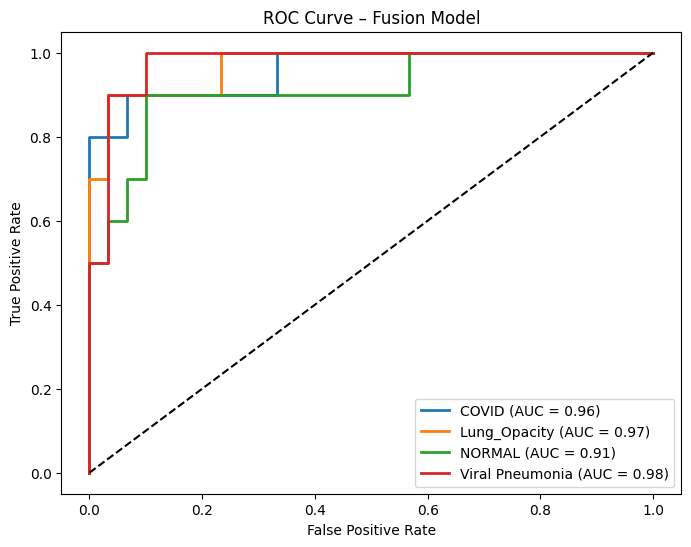

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

Predicted: COVID
True: COVID


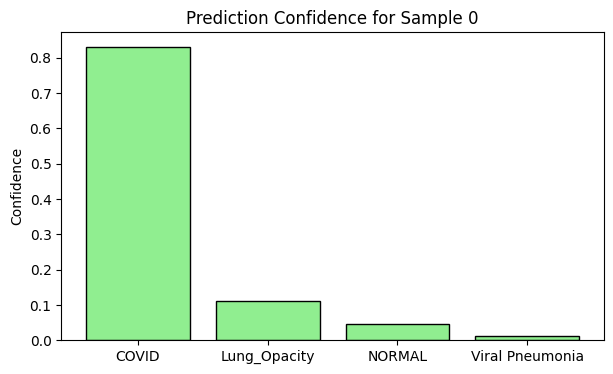


================= INTERPRETATION =================

Diagnosis: COVID
Explanation: COVID-19 infection detected. Likely ground-glass opacities and patchy consolidations.

================= SPIROMETRY ANALYSIS =================

FVC: 2.0
FEV1: 1.81
PEFR: 164.19
Severity: Moderate Obstruction

================= MISCLASSIFIED IMAGES =================

Total misclassified samples: 8


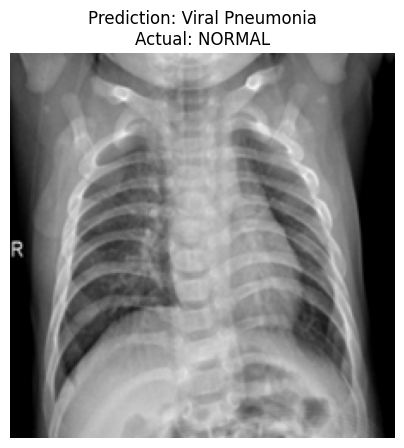


================= SUMMARY TABLE =================

            Metric     Value
0         Accuracy  0.800000
1  Macro Precision  0.800000
2     Macro Recall  0.800000
3         Macro F1  0.796212


In [ ]:
print("\n================= OUTPUT'S=================\n")
#  FULL RESULTS GENERATOR BLOCK


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve, auc
)


#  Classification Report (Accuracy, Precision, Recall, F1)

print("\n================= MODEL CLASSIFICATION REPORT =================\n")
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
print(classification_report(y_test, y_pred, target_names=class_names))

# Convert to DataFrame (for PDF style results table)
report_df = pd.DataFrame(report).transpose()
print("\n===== Classification Metrics Table =====\n")
print(report_df)



#  Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    linecolor="black",
    linewidths=1
)
plt.title("Confusion Matrix – Fusion Model", fontsize=16, weight="bold")
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.show()



#  Per-Class Accuracy

print("\n================= PER CLASS ACCURACY =================\n")
acc_per_class = cm.diagonal() / cm.sum(axis=1)
acc_df = pd.DataFrame({"Class": class_names, "Accuracy": acc_per_class})
print(acc_df)

plt.figure(figsize=(7,4))
sns.barplot(x=acc_df["Class"], y=acc_df["Accuracy"], palette="viridis")
plt.title("Per-Class Accuracy")
plt.ylim(0,1)
plt.show()



#  ROC Curves (One-vs-Rest)

plt.figure(figsize=(8,6))

# One hot encode true labels
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))

y_score = dnn.predict(X_dnn_test)

for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_oh[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve – Fusion Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



#  Prediction Probability Plot

sample_index = 0

probs = dnn.predict(X_dnn_test[sample_index].reshape(1,-1))[0]
pred_label = class_names[np.argmax(probs)]
true_label = class_names[y_test[sample_index]]

print("\nPredicted:", pred_label)
print("True:", true_label)

plt.figure(figsize=(7,4))
plt.bar(class_names, probs, color="lightgreen", edgecolor="black")
plt.title(f"Prediction Confidence for Sample {sample_index}")
plt.ylabel("Confidence")
plt.show()



#  Disease Explanation

print("\n================= INTERPRETATION =================\n")

explain = {
    "COVID": "COVID-19 infection detected. Likely ground-glass opacities and patchy consolidations.",
    "NORMAL": "Normal chest X-ray. No visible abnormal opacities.",
    "Viral Pneumonia": "Viral Pneumonia patterns—bilateral opacities and diffuse infiltrates.",
    "Lung_Opacity": "Lung opacity detected—fluid deposition or consolidation present."
}

print("Diagnosis:", pred_label)
print("Explanation:", explain[pred_label])



#  Spirometry Severity Classification

fvc, fev1, pefr = spi_test.iloc[sample_index]
severity = ""

if fev1 >= 3.0:
    severity = "Normal Lung Function"
elif 2.0 <= fev1 < 3.0:
    severity = "Mild Obstruction"
elif 1.0 <= fev1 < 2.0:
    severity = "Moderate Obstruction"
else:
    severity = "Severe Obstruction"

print("\n================= SPIROMETRY ANALYSIS =================\n")
print("FVC:", round(fvc,2))
print("FEV1:", round(fev1,2))
print("PEFR:", round(pefr,2))
print("Severity:", severity)



#  Misclassified Sample Viewer (Error Analysis)

print("\n================= MISCLASSIFIED IMAGES =================\n")

mis_idx = np.where(y_pred != y_test)[0]

if len(mis_idx) == 0:
    print("No misclassifications 🎉")
else:
    print(f"Total misclassified samples: {len(mis_idx)}")
    idx = mis_idx[0]   # show first one

    plt.figure(figsize=(5,5))
    plt.imshow(X_test[idx])
    plt.title(f"Prediction: {class_names[y_pred[idx]]}\nActual: {class_names[y_test[idx]]}")
    plt.axis("off")
    plt.show()



#  Summary

summary = {
    "Metric": ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1"],
    "Value": [
        report["accuracy"],
        report["macro avg"]["precision"],
        report["macro avg"]["recall"],
        report["macro avg"]["f1-score"]
    ]
}

summary_df = pd.DataFrame(summary)

print("\n================= SUMMARY TABLE =================\n")
print(summary_df)
